## Processing data for Pate Skene

In [1]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import colorConverter
from sklearn.neighbors import NearestNeighbors
import pickle as pkl
import loompy

from cytograph.plotting.colors import colors75


def manifold(ds: loompy.LoomConnection, out_file: str, tag1: List[str] = None, tag2: List[str] = None, embedding: str = "TSNE", feature: str = "cluster") -> None:
    n_cells = ds.shape[1]
    has_edges = False
    if "RNN" in ds.col_graphs:
        g = ds.col_graphs.RNN
        has_edges = True
    elif "MKNN" in ds.col_graphs:
        g = ds.col_graphs.MKNN
        has_edges = True
    if embedding in ds.ca:
        pos = ds.ca[embedding][:, :2]
    else:
        raise ValueError("Embedding not found in the file")
    labels = ds.ca[feature]
    if "Outliers" in ds.col_attrs:
        outliers = ds.col_attrs["Outliers"]
    else:
        outliers = np.zeros(ds.shape[1])
    # Compute a good size for the markers, based on local density
    min_pts = min(int(n_cells / 3), 50)
    eps_pct = 60
    nn = NearestNeighbors(n_neighbors=min_pts, algorithm="ball_tree", n_jobs=4)
    nn.fit(pos)
    knn = nn.kneighbors_graph(mode='distance')
    k_radius = knn.max(axis=1).toarray()
    epsilon = (2500 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)

    fig = plt.figure(figsize=(25, 10))
    ax = fig.add_axes([0, 0, 0.4, 1])

    # Draw nodes
    plots = []
    tag1_names = []
    tag2_names = []
    for i in range(max(labels) + 1):
        cluster = labels == i
        n_cells = cluster.sum()
        if np.all(outliers[labels == i] == 1):
            edgecolor = colorConverter.to_rgba('red', alpha=.1)
            plots.append(plt.scatter(x=pos[outliers == 1, 0], y=pos[outliers == 1, 1], c='grey', marker='.', edgecolors=edgecolor, alpha=0.1, s=epsilon))
            tag1_names.append(f"{i}/n={n_cells}  (outliers)")
        else:
            plots.append(plt.scatter(x=pos[cluster, 0], y=pos[cluster, 1], c=[colors75[np.mod(i, 75)]], marker='.', lw=0, s=epsilon, alpha=0.5))
            txt = str(i)
            if "ClusterName" in ds.ca:
                txt = ds.ca.ClusterName[ds.ca[feature] == i][0]
            elif 'Class_labels' in ds.ca:
                txt = ds.ca.Class_labels[ds.ca[feature] == i][0]
            if tag1 is not None:
                tag1_names.append(f"{txt}/n={n_cells} " + tag1[i].replace("\n", " "))
            else:
                tag1_names.append(f"{txt}/n={n_cells}")
            if tag2 is not None:
                tag2_names.append(f"{txt} " + tag2[i].replace("\n", " "))

    # Add legends
    if ds.ca[feature].max() <= 500:
        ax2 = fig.add_axes([0.4, 0, 0.3, 1])
        ax2.axis("off")
        ax2.legend(plots, tag1_names, scatterpoints=1, markerscale=2, loc='center', mode='expand', fancybox=True, framealpha=0.5, fontsize=12)
        if tag2 is not None:
            ax3 = fig.add_axes([0.7, 0, 0.3, 1])
            ax3.axis("off")
            ax3.legend(plots, tag2_names, scatterpoints=1, markerscale=2, loc='center', mode='expand', fancybox=True, framealpha=0.5, fontsize=12)

    for lbl in range(0, max(labels) + 1):
        txt = str(lbl)
        if "ClusterName" in ds.ca:
            txt = ds.ca.ClusterName[ds.ca[feature] == lbl][0]
        elif 'Class_labels' in ds.ca:
            txt = ds.ca.Class_labels[ds.ca[feature] == lbl][0]
        if np.all(outliers[labels == lbl] == 1):
            continue
        if np.sum(labels == lbl) == 0:
            continue
        (x, y) = np.median(pos[np.where(labels == lbl)[0]], axis=0)
        ax.text(x, y, txt, fontsize=12, bbox=dict(facecolor='white', alpha=0.5, ec='none'))

    ax.axis("off")
    fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')
    plt.close()

In [2]:
#Imports
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import loompy
from typing import *
import multiprocessing as mp
import pybedtools
from pybedtools import BedTool
import multiprocessing as mp

from chromograph.pipeline import config
from chromograph.peak_analysis.utils import *

from cytograph.species import Species
from cytograph.annotation import AutoAnnotator, AutoAutoAnnotator
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.manifold import GraphSkeletonizer
import cytograph.plotting as cgplot
from cytograph.plotting import manifold

import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

def retrieve_enrichments(ds, motif_dir, N=5):
    '''
    Retrieved the top N motifs from Homer findMotifs results
    '''
    ld = os.listdir(motif_dir)
    c_dict = {}
    for d in ld:
        n = int(d.split('_')[-1])
        mat = np.loadtxt(os.path.join(motif_dir, d, 'knownResults.txt'), dtype=str, skiprows=1)
        c_dict[n] = ' '.join([x.split('_')[0] for x in mat[:N,0]])
    
    motif_markers = np.array([c_dict[x] for x in ds.ca.Class])
    return motif_markers

def KneeBinarization(dsagg: loompy.LoomConnection, bins: int = 200, mode: str = 'linear', bounds:tuple=(40,200)):
    '''
    Identifies positive peaks for every cluster based on the decay curve of the CPM values
    
    Args:
        ds          LoomConnection to aggregated peak file
        bins        Number of bins to fit CPM scores into. Defaults to 200. User lower number for small cell counts.
                    High values can cause rougher curves.
        mode        'linear' or 'log'. Determines if values are scaled before determining inflection point. In general
                    'log' is more lenient in feature selection.
    Returns:
        peaks       Numpy array of positive peaks
        CPM_thres   Thresholds used for peak binarization in cluster
    '''
    logging.info(f'Binarize clusters by knee point')
    ## Create layer
    peaks = np.zeros(dsagg.shape)
    CPM_thres = np.zeros(dsagg.shape[1])
    failed = []
    N_pos = []

    for i in range(dsagg.shape[1]):

        if mode == 'linear':
            vals = dsagg['CPM'][:,i]
            values, base = np.histogram(vals, bins = bins)
            cumulative = np.cumsum(values)

            x = base[:-1]
            y = len(vals)-cumulative

            kn = KneeLocator(x, y, curve='convex', direction='decreasing', interp_method='polynomial')
            t = kn.knee

            if (t > bounds[1]) or (t < bounds[0]):
                failed.append(i)

            else:
                CPM_thres[i] = t
                valid = vals > t
                N_pos.append(np.sum(valid))
                peaks[:,i] = valid


        elif mode == 'log':
            vals = np.log10(dsagg['CPM'][:,i]+1)
            values, base = np.histogram(vals, bins = bins)
            cumulative = np.cumsum(values)

            x = base[:-1]
            y = np.log10((len(vals)-cumulative)+1)

            kn = KneeLocator(x, y, curve='concave', direction='decreasing', interp_method='polynomial')
            t = 10**kn.knee
            
            if t > bounds[1]:
                failed.append(i)

            else:
                CPM_thres[i] = t
                valid = vals > np.log10(t)
                N_pos.append(np.sum(valid))
                peaks[:,i] = valid

        else:
            logging.info('No correct mode selected!')
            return
        
    ## Set threshold in accordance with mean number of positive features
    if len(failed) > 0:
        logging.info(f'failed to set threshold in {len(failed)} clusters')
        N_feat = np.mean(N_pos)
        for i in failed:
            vals = dsagg['CPM'][:,i]
            t = np.quantile(vals, 1-(N_feat/vals.shape[0]))
            CPM_thres[i] = t
            peaks[:,i] = vals > t

    return peaks, CPM_thres

class Peak_Aggregator:
    def __init__(self) -> None:
        '''
        Aggregate the Peak matrix
        '''
        self.config = config.load_config()

    def fit(self, ds: loompy.LoomConnection, out_file: str, agg_spec: Dict[str, str] = None) -> None:
        '''
        Aggregate the matrix, find markers and annotate enriched motifs by homer
        
        Args:
            ds              LoomConnection. Dataset must contain ds.ra.Gene and ds.ca.Clusters
            outfile         Filename of aggregation file
            agg_spec        Dictionary containing numpy-groupies function to be applied to column attributes
        '''
        self.outdir = '/' + os.path.join(*out_file.split('/')[:-1], 'exported')
        self.motifdir = '/' + os.path.join(*out_file.split('/')[:-1], 'motifs')

        agg_spec = {
            "Age": "mean",
            "Clusters": "tally",
            "Class": "first",
            "Class_labels": "first"
            "NPeaks": "mean",
            "Sex": "tally",
            "Tissue": "tally",
            "Chemistry": "tally",
            "SampleID": "tally",
            "TissuePool": "first",
            "Outliers": "mean",
            "PCW": "mean"
        }
        
        cells = ds.col_attrs["Class"] >= 0
        labels = ds.col_attrs["Class"][cells]
        n_labels = len(set(labels))

        logging.info("Aggregating Classes")
#         ds.aggregate(out_file, None, "Class", "sum", agg_spec)
        with loompy.connect(out_file) as dsout:

            if n_labels <= 1:
                return

            logging.info('Calculate coverage metrics')
            dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
            dsout.ra.NCells = dsout.map([np.sum], axis=0)[0]
            dsout.ca.NCells = np.bincount(labels, minlength=n_labels)
            
            dsout.permute(ordering=dsout.ca.Class.argsort(), axis=1)

            ## Normalize peak counts by total fragments per cluster
            logging.info('Convert to CPMs')
            dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)

            ## Call positive and negative peaks for every cluster
            dsout['binary'], dsout.ca['CPM_thres'] = KneeBinarization(dsout, bounds=(5,40))

            ## Select markers by residuals
            markers = Enrichment_by_residuals(dsout)

            # Redo the Ward's linkage just to get a tree that corresponds with the new ordering
            data = dsout[:, :][markers, :].T
            data[np.where(data<0)] = 0  ## BUG handling. Sometimes values surpass the bit limit in malignant cells
            data = np.log(data + 1)
            D = pdist(data, 'correlation')
            dsout.attrs.linkage = hc.linkage(D, 'ward', optimal_ordering=True)

            ## Run Homer findMotifs to find the top 5 motifs per cluster
            logging.info(f'Finding enriched motifs among marker peaks')
            
            if not os.path.isdir(self.motifdir):
                os.mkdir(self.motifdir) 

            piles = []
            for x in range(dsout.shape[1]):
                Valids = dsout.layers['marker_peaks'][:,x]
                bed_file = os.path.join(self.motifdir, f'Class_{x}.bed')
                peaks = BedTool([(dsout.ra['Chr'][x], str(dsout.ra['Start'][x]), str(dsout.ra['End'][x]), str(dsout.ra['ID'][x]), '.', '+') for x in np.where(Valids)[0]]).saveas(bed_file)
                piles.append([bed_file, os.path.join(self.motifdir, f'Cluster_{x}')])

            for pile in piles:
                Homer_find_motifs(bed=pile[0], outdir=pile[1], homer_path=self.config.paths.HOMER, motifs=os.path.join(chromograph.__path__[0], 'references/human_TFs.motifs'), cpus=mp.cpu_count())

            dsout.ca.Enriched_Motifs = retrieve_enrichments(dsout, self.motifdir, N=self.config.params.N_most_enriched)

            # logging.info("Graph skeletonization")
            GraphSkeletonizer(min_pct=1).abstract(ds, dsout)

            ## Plot results 
            name = out_file.split('/')[-1].split('_')[0]
            if 'UMAP' in ds.ca:
                logging.info("Plotting UMAP")
                manifold(ds, os.path.join(self.outdir, f"{name}_peaks_UMAP.png"), list(dsout.ca.Enriched_Motifs), embedding = 'UMAP')
            logging.info("Plotting TSNE")
            manifold(ds, os.path.join(self.outdir, f"{name}_peaks_TSNE.png"), list(dsout.ca.Enriched_Motifs), embedding = 'TSNE')

            ## Plotting neighborhoods and metromap
            cgplot.radius_characteristics(ds, os.path.join(self.outdir, f"{name}_neighborhouds.png"))
            cgplot.metromap(ds, dsout, os.path.join(self.outdir, f"{name}_metromap.png"), embedding = 'TSNE')

            return

# f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'
# f_agg = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.agg.loom'
        
# with loompy.connect(f) as ds:
#     PA = Peak_Aggregator()
#     PA.fit(ds, f_agg)

SyntaxError: invalid syntax (<ipython-input-2-2d17a5f49dfc>, line 151)

In [ ]:
## Imports
import os
import sys
import collections
import loompy
from tqdm import tqdm
from typing import *
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

from collections import Counter
from pynndescent import NNDescent

import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.pipeline import config
from chromograph.RNA.utils import *
from chromograph.plotting.sample_distribution_plot import sample_distribution_plot

import cytograph as cg
import cytograph.plotting as cgplot
from cytograph.species import Species
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.species import Species
from cytograph.annotation import AutoAnnotator, AutoAutoAnnotator
from cytograph.enrichment import Trinarizer

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

from typing import Tuple, List

import numpy as np

import loompy


class AutoAutoAnnotator:
	"""
	Automatically discover suitable auto-annotation marker combinations
	"""
	def __init__(self, pep: float = 0.05, n_genes: int = 6, genes_allowed: np.ndarray = None) -> None:
		self.pep = pep
		self.n_genes = max(2, n_genes)
		self.genes_allowed = genes_allowed
	
	def fit(self, dsagg: loompy.LoomConnection) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
		"""
		Find highly specific and robust auto-annotation gene sets for all clusters in the file
		Returns:
			selected		The selected genes (indexes into the rows), shape (n_genes, n_clusters)
			selectivity		The cumulative selectivity (number of clusters identified), shape (n_genes, n_clusters)
			specificity		The cumulative specificity (difference in probabililty of identifying the cluster,
							relative to the second likeliest cluster), shape (n_genes, n_clusters)
			robustness		The cumulative robustness (probability of identifying the cluster), shape (n_genes, n_clusters)
		"""
		blocked = np.in1d(dsagg.ra.Gene, ['Xist', 'Tsix', 'Junb', 'Fos', 'Egr1', 'Jun']).nonzero()[0]

		trinaries = dsagg.layer["trinaries"][:, :]
		enrichment = dsagg.layer["enrichment"][:, :]
		n_clusters = dsagg.shape[1]
		positives = (trinaries > (1 - self.pep)).astype('int')
		genes = np.where(np.logical_and(positives.sum(axis=1) < n_clusters * 0.5, positives.sum(axis=1) > 0))[0]
		if self.genes_allowed is not None:
			genes = np.intersect1d(genes, self.genes_allowed)
	
		# Select the most enriched gene in each cluster
		gene1 = []  # type: List[int]
		for ix in range(dsagg.shape[1]):
			candidates = np.where(positives[:, ix] == 1)[0]
			candidates = np.setdiff1d(candidates, blocked)
			ordering = np.argsort(-enrichment[candidates, ix])
			try:
				gene1.append(candidates[ordering][0])
			except IndexError:
				gene1.append(0)  # NOTE NOTE NOTE very bad patch but I want to make it run to the end
		selected = np.array(gene1)[None, :]

		# Select the most enriched most specific gene for each cluster, given genes previously selected
		for _ in range(self.n_genes - 1):
			gene2 = []
			for ix in range(dsagg.shape[1]):
				# For each gene, the number of clusters where it's positive, shape (n_genes)
				breadth = (positives * np.prod(positives[selected[:, ix]], axis=0)).sum(axis=1)
				# The genes that are expressed in cluster ix, excluding previously selected and blocked genes
				candidates = np.where(positives[:, ix] == 1)[0]
				candidates = np.setdiff1d(candidates, selected)
				candidates = np.setdiff1d(candidates, blocked)
				try:
					# Now select the most specific gene, ranked by enrichment
					narrowest = breadth[candidates][breadth[candidates].nonzero()].min()
					candidates = np.intersect1d(candidates, np.where(breadth == narrowest)[0])
					ordering = np.argsort(-enrichment[candidates, ix])
					gene2.append(candidates[ordering][0])
				except (IndexError, ValueError):
					gene2.append(0)  # NOTE NOTE NOTE very bad patch but I want to make it run to the end
			gene2 = np.array(gene2)
			selected = np.vstack([selected, gene2])

		selectivity = np.cumprod(positives[selected], axis=0).sum(axis=1)
		robustness = np.array([np.cumprod(trinaries[selected[:, ix], ix]) for ix in np.arange(n_clusters)]).T

		specificity = []
		for c in np.arange(n_clusters):
			a = np.cumprod(trinaries[selected[:, :], c], axis=0)
			vals = []
			for ix in np.arange(5):
				temp = np.sort(a[ix, :])[-2:]
				vals.append(temp[-1] - temp[-2])
			specificity.append(vals)
		specificity = np.array(specificity).T

		return (selected, selectivity, specificity, robustness)

	def annotate(self, ds: loompy.LoomConnection) -> None:
		"""
		Annotate the loom file with marker gene sets based on auto-auto-annotation
		Remarks:
			Creates the following column attributes:
				MarkerGenes			Space-separated list of six marker genes
				MarkerSelectivity	Space-separated list of cumulative selectivity
				MarkerSpecificity	Space-separated list of cumulative specificity
				MarkerRobustness	Space-separated list of cumulative robustness
			
			See the fit() method for definitions of the metrics
		"""
		(selected, selectivity, specificity, robustness) = self.fit(ds)
		n_clusters = ds.shape[1]
		ds.ca.MarkerGenes = [" ".join(ds.ra.Gene[selected[:, ix]]) for ix in np.arange(n_clusters)]
		ds.ca.MarkerSelectivity = [" ".join([str(x) for x in selectivity[:, ix]]) for ix in np.arange(n_clusters)]
		ds.ca.MarkerSpecificity = [" ".join([f"{x:.2}" for x in specificity[:, ix]]) for ix in np.arange(n_clusters)]
		ds.ca.MarkerRobustness = [" ".join([f"{x:.2}" for x in robustness[:, ix]]) for ix in np.arange(n_clusters)]

class RNA_analysis():
    def __init__(self, ds, outdir):
        '''
        '''
        self.peak_file = ds.filename
        self.name = ds.filename.split('/')[-2]
        self.RNA_file = '/' + os.path.join(*ds.filename.split('/')[:-1], f'{self.name}_RNA.loom')
        self.RNA_agg = '/' + os.path.join(*ds.filename.split('/')[:-1], f'{self.name}_RNA.agg.loom')
        self.Imputed_file = '/' + os.path.join(*ds.filename.split('/')[:-1], f'{self.name}_RNA_imputed.loom')
        self.peak_agg = '/' + os.path.join(*ds.filename.split('/')[:-1], f'{self.name}_peaks.agg.loom')
        self.config = config.load_config()
        self.outdir = os.path.join(outdir, 'exported')
        
    def generate_RNA_file(self, RNA_files_dir):
        '''
        '''
        
        with loompy.connect(self.peak_file) as ds:
            samples = np.unique(ds.ca.Name[np.where(ds.ca.Chemistry == 'multiome_atac')[0]])
            inputfiles = [os.path.join(RNA_files_dir, f"{sample}.loom") for sample in samples]

            selections = []
            for sample, file in zip(samples, inputfiles):
                valid_cells = set(ds.ca.CellID)
                ## Get cells passing filters
                with loompy.connect(file, 'r') as ds2:
                    barcodes = rna_barcodes_to_atac(ds2)
                    if len(ds.ca.CellID[0].split('/')[-1].split('-')) > 1:
                        barcodes = [x + '-1' for x in barcodes]
                    good_cells = np.array([x in valid_cells for x in barcodes])
                    selections.append(good_cells)

            if os.path.isfile(self.RNA_file):
                os.remove(self.RNA_file)
            logging.info(f'Combining files')
            loompy.combine_faster(inputfiles, self.RNA_file, selections=selections, key='Accession')

            ## transcribe cell IDs
            with loompy.connect(self.RNA_file) as dsout:
                dsout.ca.RNA_IDs = dsout.ca.CellID
                dsout.ca.CellID = rna_barcodes_to_atac(dsout)

                match = {k:v for v, k in enumerate(ds.ca.CellID)}
                if len(ds.ca['CellID'][0].split('-'))> 1:
                    new_order = np.array([match[x + '-1'] for x in dsout.ca['CellID']])
                else:
                    new_order = np.array([match[x] for x in dsout.ca['CellID']])

                for k in ds.ca:
                    if k != 'CellID':
                        dsout.ca[k] = ds.ca[k][new_order]
                
                if self.name == 'All':
                    logging.info(f'Plotting sample distribution')
                    sample_distribution_plot(dsout, os.path.join(self.outdir, f"{self.name}_RNA_cell_counts.png"))
            logging.info(f'Finished creating file')  
        
    def Impute_RNA(self):
        '''
        '''
        
        if not os.path.isfile(self.RNA_file):
            logging.info(f'Generate the merged RNA file first!')
            return
        
        logging.info(f'Imputing RNA layer')
        
        ## Generate Imputation file
        if os.path.isfile(self.Imputed_file):
            os.remove(self.Imputed_file)

        with loompy.connect(self.peak_file) as ds:
            with loompy.connect(self.RNA_file) as dsr:
                RNA_barcodes = set(dsr.ca.CellID)
                x = np.array([x not in RNA_barcodes for x in ds.ca.CellID])
                cells = np.where(x)[0]
                M = dsr.shape[0]
                N = ds.shape[1]

                RNA_barcodes = set(dsr.ca.CellID)

                if len(ds.ca['CellID'][0].split('-'))> 1:
                    x = [x.split('-')[0] not in RNA_barcodes for x in ds.ca.CellID]
                    new_barcodes = ds.ca.CellID[x]
                    rna_bars = [x + '-1' for x in dsr.ca.CellID]
                    all_barcodes = np.concatenate([rna_bars, new_barcodes])
                else:
                    x = [x not in RNA_barcodes for x in ds.ca.CellID]
                    new_barcodes = ds.ca.CellID[x]
                    all_barcodes = np.concatenate([dsr.ca.CellID, new_barcodes])

                if ds.shape[1] > 10000:
                    batch = 1024
                    M = dsr.shape[0]
                    N = batch
                    empty_mat = sparse.csr_matrix((M,N), dtype=dsr[''].dtype)
                    cols = {'CellID': all_barcodes[:batch]}
                    logging.info(f'Create file')
                    loompy.create(self.Imputed_file, empty_mat, dsr.ra, cols)

                    with loompy.connect(self.Imputed_file) as dsout:
                        n_iter = np.ceil(ds.shape[1] / batch).astype(int)

                        pbar = tqdm(len(all_barcodes))
                        for i in range(1,n_iter):
                            start = i * batch
                            end = (i+1) * batch
                            if end > ds.shape[1]:
                                end = ds.shape[1]

                            N = end - start
                            empty_mat = np.zeros((M,N), dtype=dsr[''].dtype)
                            dsout.add_columns({'': empty_mat}, col_attrs={'CellID': all_barcodes[start:end]}, row_attrs=ds.ra)
                            pbar.update(batch)
                        pbar.close()
                 
                else:
                    empty_mat = sparse.csr_matrix((M,N), dtype=dsr[''].dtype)
                    logging.info(f'Creating file')
                    loompy.create(self.Imputed_file, empty_mat, dsr.ra, {'CellID': all_barcodes})

                with loompy.connect(self.Imputed_file) as dsi:
                    logging.info(dsi.shape)

                    ## Tranfer RNA data
                    for layer in dsr.layers:
                        if layer not in dsi.layers:
                            dsi[layer] = "uint16"
                        s = dsr[layer].shape
                        dsi[layer][:,:s[1]] = dsr[layer][:,:]

                    ## Transfer column attributes
                    logging.info(f'Transfer attributes')
                    transfer_ca(ds, dsi, 'CellID')

        with loompy.connect(self.RNA_file) as dsr:
            with loompy.connect(self.Imputed_file) as dsi:

                anchors = np.where(dsi.ca.Chemistry=='multiome_atac')[0]
                id_to_anchor = {i: a for i,a in enumerate(anchors)}
                queries = np.where(dsi.ca.Chemistry!='multiome_atac')[0]
                id_to_query = {i: a for i,a in enumerate(queries)}

                index = NNDescent(dsi.ca.LSI[anchors])

                X = index.query(dsi.ca.LSI[queries],10)

                data = X[1]
                max_d = np.max(data)
                data = (max_d - data) / max_d

                new_pos = []
                new_origin = []
                for i, row in enumerate(X[0]):
                    new_pos.append([id_to_anchor[x] for x in row])
                    new_origin.append([id_to_query[i] for x in range(len(row))])
                new_pos = np.array(new_pos)   
                new_origin = np.array(new_origin)

                nn = sparse.csr_matrix((data.flatten(), (new_origin.flatten(),new_pos.flatten())), shape=(dsi.shape[1],dsi.shape[1]), dtype='float')
                nn.eliminate_zeros()
                nn[anchors,anchors] = 1
                dsi.col_graphs['anchor_net'] = nn

                total_link = np.asarray(div0(1, np.sum(nn, axis=1))).reshape(-1)                    
                sources, targets = nn.nonzero()
                r = np.array([total_link[x] for x in sources])
                v = nn.data.flatten() * r
                scaled = sparse.csr_matrix((v, (sources,targets)), shape=nn.shape, dtype='float')

                logging.info(f'Pooling')
                dsi["pooled"] = 'int32'
                progress = tqdm(total = dsi.shape[0])
                if "spliced" in dsi.layers:
                    dsi["spliced_pooled"] = 'int32'
                    dsi["unspliced_pooled"] = 'int32'
                    for (_, indexes, view) in dsi.scan(axis=0, layers=["spliced", "unspliced"], what=["layers"]):
                        X = view.layers["spliced"][:, :] @ scaled.T
                        dsi["spliced_pooled"][indexes.min(): indexes.max() + 1, :] = view.layers["spliced"][:, :] @ scaled.T
                        dsi["unspliced_pooled"][indexes.min(): indexes.max() + 1, :] = view.layers["unspliced"][:, :] @ scaled.T
                        dsi["pooled"][indexes.min(): indexes.max() + 1, :] = dsi["spliced_pooled"][indexes.min(): indexes.max() + 1, :] + dsi["unspliced_pooled"][indexes.min(): indexes.max() + 1, :]
                        progress.update(512)
                else:
                    for (_, indexes, view) in dsi.scan(axis=0, layers=[""], what=["layers"]):
                        dsi["pooled"][indexes.min(): indexes.max() + 1, :] = view[:, :] @ scaled.T
                        
                progress.close()

                logging.info(f"Inferring cell cycle")
                species = Species.detect(dsi)
                CellCycleAnnotator(species).annotate(dsi, layer='pooled')
                cgplot.cell_cycle(dsi, os.path.join(self.outdir, self.name + "_cellcycle.png"))

    def annotate(self, min_cells:int=10, agg_spec=None, agg_label:str='Clusters'):
        '''
        '''
        if agg_spec == None:
            agg_spec = {
            "Age": "mean",
            "Clusters": "first",
            "Class": "first",
            "Total": "mean",
            "Sex": "tally",
            "Tissue": "tally",
            "Chemistry": "tally",
            "SampleID": "tally",
            "TissuePool": "first",
            "Outliers": "mean",
            "PCW": "mean"
            }
        if not os.path.isfile(self.RNA_file):
            logging.info(f'Generate RNA file first!')
            return
            
        with loompy.connect(self.RNA_file) as ds:
            cells = ds.col_attrs[agg_label] >= 0
            labels = ds.col_attrs[agg_label][cells]
            n_labels = len(set(labels))

            logging.info(f'Aggregating file')
            ds.aggregate(self.RNA_agg, None, agg_label, "mean", agg_spec)

            with loompy.connect(self.RNA_agg) as dsout:
                dsout.ca.NCells = np.bincount(labels, minlength=n_labels)[dsout.ca[agg_label]]

                logging.info("Computing cluster gene enrichment scores")
                fe = FeatureSelectionByMultilevelEnrichment(labels_attr="Class", mask=Species.detect(ds).mask(dsout, ("cellcycle", "sex", "ieg", "mt")))
                markers = fe.fit(ds)
                dsout.layers["enrichment"] = fe.enrichment

                # Renumber the clusters
                logging.info("Renumbering clusters by similarity, and permuting columns")

                data = np.log(dsout[:, :] + 1)[markers, :].T
                D = pdist(data, 'correlation')
                Z = hc.linkage(D, 'ward', optimal_ordering=True)
                ordering = hc.leaves_list(Z)

                # Redo the Ward's linkage just to get a tree that corresponds with the new ordering
                data = np.log(dsout[:, :] + 1)[markers, :].T
                D = pdist(data, 'correlation')
                dsout.attrs.linkage = hc.linkage(D, 'ward', optimal_ordering=True)

                # Reorder the genes, markers first, ordered by enrichment in clusters
                logging.info("Permuting rows")
                mask = np.zeros(ds.shape[0], dtype=bool)
                mask[markers] = True
                # fetch enrichment from the aggregated file, so we get it already permuted on the column axis
                gene_order = np.zeros(ds.shape[0], dtype='int')
                gene_order[mask] = np.argmax(dsout.layer["enrichment"][mask, :], axis=1)
                gene_order[~mask] = np.argmax(dsout.layer["enrichment"][~mask, :], axis=1) + dsout.shape[1]
                gene_order = np.argsort(gene_order)
                ds.permute(gene_order, axis=0)
                dsout.permute(gene_order, axis=0)
        
                logging.info(f'Trinarizing')
                trinaries = Trinarizer(0.2).fit(ds)
                dsout['trinaries'] = trinaries[:,dsout.ca[agg_label]]

                logging.info(f'Annotating')
                AutoAnnotator(self.config.paths.autoannotation, ds=dsout).annotate(dsout)

                logging.info("Computing auto-auto-annotation")
                AutoAutoAnnotator(n_genes=6).annotate(dsout)        
                
                ## Remove undersampled clusters
                remove = dsout.ca.NCells < min_cells
                logging.info(f'Clusters with too few measurements: {dsout.ca[agg_label][remove]}')
                for k in ['AutoAnnotation', 'MarkerGenes', 'MarkerRobustness', 'MarkerSelectivity', 'MarkerSpecificity']:
                    new_attr = dsout.ca[k]
                    new_attr[remove] = ''
                    dsout.ca[k] = new_attr

        ## Export the labels to the peak_aggregate file
        logging.info(f'Tranferring labels to peak aggregate file')
        with loompy.connect(self.RNA_agg) as dsagg:
            with loompy.connect(self.peak_agg) as dsout:
                annot = np.repeat('', dsout.shape[1]).astype('U128')
                annot[dsagg.ca[agg_label]] = dsagg.ca.AutoAnnotation
                dsout.ca.AutoAnnotation = annot

                annot = np.repeat('', dsout.shape[1]).astype('U128')
                annot[dsagg.ca[agg_label]] = dsagg.ca.MarkerGenes
                dsout.ca.MarkerGenes = annot      
                
        with loompy.connect(self.peak_file) as ds:
            with loompy.connect(self.peak_agg) as dsagg:
                cgplot.manifold(ds, os.path.join(self.outdir, f"{self.name}_Annotations.png"), list(dsagg.ca.MarkerGenes), list(dsagg.ca.AutoAnnotation), embedding = 'TSNE')
                
# f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'
# f_agg = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.agg.loom'

# with loompy.connect(f, 'r') as ds:
#     RA = RNA_analysis(ds, '/datb/sl/camiel/HARs/CB_Skene/Cerebellum')
# RA.generate_RNA_file("/proj/loom")
# RA.annotate(agg_label='Class')

In [ ]:
f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'

classes = {
'Endo': [65,  66],
'Peri': [64],
'Mgl': [63],
'RGL': [44, 45,  46,  48,  54, 55, 59, 61],
'Progenitors': [41, 42, 43, 49, 50,  51, 52,  53, 56,  57, 58,  60],
'uRL': [18,  19, 20, 21, 22, 23, 28, 29],
'VZ_prog': [31, 32, 33],
'RP': [26],
'GABA_prog': [11, 34, 35, 36],
'GABA': [27,  47],
'GABA_2': [11, 36],
'Purk_1': [6, 7, 9, 10, 12, 13, 14, 17],
'Purk_2': [0, 1, 2, 3, 4, 5, 8, 15, 16],
# 'GLUT_prog': [24, 25, 30,  37,39, 40],
'CN': [37, 39, 40],
'GNP': [24, 25, 30],
'unannotated': [38, 62]
}

cluster_to_class = {}

with loompy.connect(f) as ds:
    all_clusters = np.unique(ds.ca.Clusters)

included = np.unique([x for k, s in classes.items() for x in s])
missed = [x for x in all_clusters if x not in included]
print(missed)

for k in classes:
    for c in classes[k]:
        cluster_to_class[c] = k
        
with loompy.connect(f) as ds:
#     ds.ca.Class_labels = np.array([cluster_to_class[x] for x in ds.ca.Clusters])
#     d = {k:v for v, k in enumerate(np.unique(ds.ca.Class_labels))}
#     ds.ca.Class = np.array([d[x] for x in ds.ca.Class_labels])
#     logging.info(f'permute dataset')
    ds.permute(np.argsort(ds.col_attrs["Class"]), axis=1)  ## Order by class label

[]


In [ ]:
## Aggregate file

f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'
f_agg = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.agg.loom'
        
with loompy.connect(f) as ds:
    PA = Peak_Aggregator()
    PA.fit(ds, f_agg)

17:52:35 INFO     Aggregating Classes
17:52:36 INFO     Calculate coverage metrics
17:52:50 INFO     Convert to CPMs
17:52:52 INFO     Binarize clusters by knee point
17:53:01 INFO     Calculating residuals
17:53:04 INFO     Calculating fold change and selecting markers
17:53:46 INFO     Finding enriched motifs among marker peaks


In [14]:
f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'
# f_agg = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.agg.loom'
with loompy.connect(f, 'r+') as ds:
    print(ds.ca.keys())
    
    if not np.array_equal(ds.ca.Class, ds.ca.Clusters):
        print('.')
        ds.ca.Clusters_old = ds.ca.Clusters
        ds.ca.Clusters = ds.ca.Class

['Age', 'Agetext', 'Ageunit', 'All_fc_analysis_id', 'Analysis', 'CellID', 'Chemistry', 'Class', 'Class_labels', 'Clusters', 'ClustersModularity', 'ClustersModularity_bin', 'ClustersSurprise', 'Cmobarcodes', 'Comment', 'Datecaptured', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'Editat', 'Editby', 'FRIP', 'FRtss', 'GA_colsum', 'GA_pooled_colsum', 'Id', 'LSI', 'LSI_b', 'Label', 'Method', 'NBins', 'NPeaks', 'Name', 'Neuronprop', 'Numpooledanimals', 'Outliers', 'OutliersModularity', 'OutliersModularity_bin', 'OutliersSurprise', 'Plugdate', 'Project', 'PseudoAge', 'Roi', 'Sampleok', 'Sex', 'Shortname', 'Species', 'Strain', 'TSNE', 'TSNE_bin', 'TSS_fragments', 'Tissue', 'Transcriptome', 'UMAP', 'UMAP3D', 'UMAP3D_bin', 'UMAP_bin', 'barcode', 'chimeric', 'duplicate', 'excluded_reason', 'is__cell_barcode', 'lowmapq', 'mitochondrial', 'passed_filters', 'peak_region_cutsites', 'peak_region_fragments', 'preClusters', 'total', 'unmapped']
.


In [27]:
##  RNA analysis

f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'

with loompy.connect(f, 'r') as ds:
    RA = RNA_analysis(ds, '/datb/sl/camiel/HARs/CB_Skene/Cerebellum')
RA.generate_RNA_file("/proj/loom")
RA.annotate(agg_label='Class')

09:50:21 INFO     Combining files
09:51:36 INFO     Finished creating file
09:51:36 INFO     Aggregating file
09:51:48 INFO     Computing cluster gene enrichment scores
09:51:49 INFO     Multilevel marker selection with 16 clusters at the leaf level
09:51:49 INFO     Analyzing 2 higher levels with [5, 2] clusters
09:51:49 INFO     Computing enrichment statistic
/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
09:52:29 INFO     Identifying valid genes
09:52:36 INFO     Found 160 marker genes at level 0 (leaves)
09:52:36 INFO     Computing enrichment statistic
09:53:14 INFO     Found 50 marker genes at level 1
09:53:14 INFO  

In [34]:
f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'
f_agg = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.agg.loom'
with loompy.connect(f, 'r') as ds:
    with loompy.connect(f_agg) as dsout:
        name = 'Cerebellum'
        manifold(ds, os.path.join('/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/', f"{name}_TSNE.png"), list(dsout.ca.Enriched_Motifs), embedding = 'TSNE')
        manifold(ds, os.path.join('/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/', f"{name}_UMAP.png"), list(dsout.ca.Enriched_Motifs), embedding = 'UMAP')

In [36]:
dx = {}
with loompy.connect(f, 'r') as ds:
    for i in np.unique(ds.ca.Class):
        label = ds.ca.Class_labels[ds.ca.Class==i][0]
        dx[i] = label

In [41]:
with loompy.connect(f_agg) as dsagg:
    dsagg.ca.Class_labels = np.array([dx[i] for i in dsagg.ca.Class])
    for i in range(dsagg.shape[1]):
        print(f'{dsagg.ca.Class_labels[i]}: {dsagg.ca.Enriched_Motifs[i]}')

CN: NOBOX PRRX2 LHX2 COE1 DLX3 HXB4
Endo: TGIF1 MEIS2 NOBOX HXB4 PBX1 PKNX1
GABA: NOBOX PRRX2 LHX2 COE1 AP2A DLX3
GABA_2: SOX3 SOX2 SOX4 SOX9 SOX10 SOX5
GABA_prog: NOBOX PRRX2 LHX2 DLX3 COE1 LHX3
GNP: AP2A COE1 AP2C LHX2 PO2F2 NOBOX
Mgl: GATA1 GATA2 TAL1 GATA4 GATA6 GATA3
Peri: GATA1 GATA2 TAL1 GATA4 GATA6 GATA3
Progenitors: NFIA NFIC SOX9 SOX10 SOX3 TGIF1
Purk_1: SOX3 SOX2 SOX10 SOX9 SOX5 SOX4
Purk_2: NDF1 ATOH1 NDF2 OLIG2 PTF1A LYL1
RGL: NFIA NFIC SOX10 RFX3 SOX9 STAT4
RP: NOBOX PRRX2 LHX2 COE1 DLX3 AP2A
VZ_prog: NOBOX PRRX2 COE1 LHX2 DLX3 AP2A
uRL: COE1 AP2A AP2C PRRX2 NOBOX LHX2
unannotated: NOBOX PRRX2 COE1 LHX2 DLX3 HXB4


In [47]:
with loompy.connect() as ds:
    for i in range(ds.shape[1]):
        print(f'{ds.ca.Class_labels[i]}: {ds.ca.MarkerGenes[i]}')

CN: IL1RAPL2 ZNF804B MEIS2 LINC01322 LHX9 VWDE
Endo: 
GABA: PAX2 SLC6A5 KLHL14 ZNF385B CRYBG3 NEUROD2
GABA_2: RIT2 C8orf34 KCNQ5 LINC01210 SLC24A4 CHRM3
GABA_prog: ROBO3 LINC00535 GRIK3 ZBTB16 CRYBG3 ADRA1A
GNP: FSTL4 CPNE4 AC096570.1 BARHL1 RBFOX3 NRN1
Mgl: APOE DOCK8 CCL3 FYB1 CCL3L1 SAMSN1
Peri: DLC1 RGS5 IGFBP7 EPAS1 EDNRA BGN
Progenitors: ADAMTSL1 LINC01508 AC092957.1 PIEZO2 SHROOM3 CYP26B1
Purk_1: SLIT2 EPHA5-AS1 BHLHE22 CHMP2B TRPC3 ETV1
Purk_2: SORCS1 ARNTL2 MGAT4C LINC00290 SLC24A3 TENM3-AS1
RGL: BCAN LRP2 SMOC1 TNC MEGF10 ADGRV1
RP: LMX1A CRHBP SLC17A6 GPC6 C1QL3 AC007614.1
VZ_prog: RGS16 PRDM13 TFAP2B ASCL1 LMO1 PDGFD
uRL: SSTR2 ATOH8 NPTX2 LINC01697 ATOH1 AL137017.1
unannotated: HBA1 AC108169.1 HBG1 HBG2 HBA2 TENM3-AS1


In [123]:
with loompy.connect(f, 'r') as ds:
    with loompy.connect(RA.RNA_agg) as dsout:
        name = 'Cerebellum'
        manifold(ds, os.path.join('/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/', f"{name}_TSNE.png"), embedding = 'TSNE', feature = 'Class')
        manifold(ds, os.path.join('/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/', f"{name}_UMAP.png"), embedding = 'UMAP', feature = 'Class')
        
        ## RNA
        manifold(ds, os.path.join('/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/', f"{name}_RNA_TSNE.png"), list(dsout.ca.MarkerGenes), list(dsout.ca.AutoAnnotation), embedding = 'TSNE', feature = 'Class')
        manifold(ds, os.path.join('/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/', f"{name}_RNA_UMAP.png"), list(dsout.ca.MarkerGenes), list(dsout.ca.AutoAnnotation), embedding = 'UMAP', feature = 'Class')

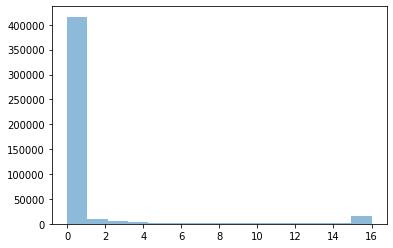

In [51]:
with loompy.connect(f_agg) as ds:
    N_clusters_active = ds['binary'].map([np.sum], axis=0)[0]
    plt.hist(N_clusters_active, bins=15, alpha=.5)

In [52]:
print(np.sum(N_clusters_active>0))
print(np.sum(N_clusters_active==1))
print(np.sum(N_clusters_active==15))

59703
10721
1360


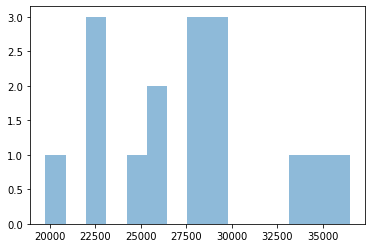

In [53]:
with loompy.connect(f_agg) as ds:
    N_peaks_active = ds['binary'].map([np.sum], axis=1)[0]
    plt.hist(N_peaks_active, bins=15, alpha=.5)

['Age', 'AutoAnnotation', 'CPM_thres', 'Chemistry_multiome_atac', 'Chemistry_v1', 'Chemistry_v1_1', 'Class', 'Class_labels', 'Clusters_0', 'Clusters_1', 'Clusters_10', 'Clusters_11', 'Clusters_12', 'Clusters_13', 'Clusters_14', 'Clusters_15', 'Clusters_2', 'Clusters_3', 'Clusters_4', 'Clusters_5', 'Clusters_6', 'Clusters_7', 'Clusters_8', 'Clusters_9', 'Enriched_Motifs', 'MarkerGenes', 'NCells', 'NPeaks', 'Outliers', 'Sex_', 'TSNE', 'Tissue_Cerebellum', 'Total', 'UMAP', 'totals']


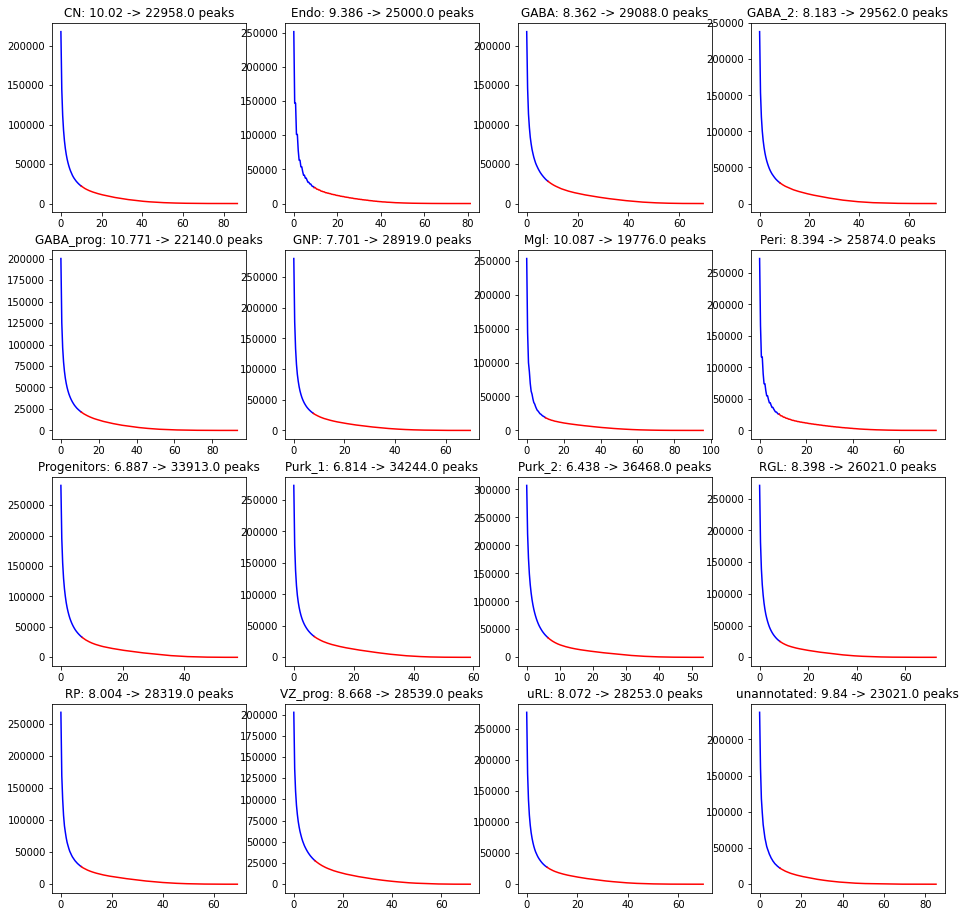

In [55]:
class_to_label = {v:k for k,v in d.items()}
with loompy.connect(f_agg) as ds:
    print(ds.ca.keys())

    fig, ax = plt.subplots(4,4, figsize=(16, 16))
    ax = ax.flatten()
    
    for i in range(ds.shape[1]):
        t = ds.ca.CPM_thres[i]
        
        vals = ds['CPM'][:,i]
        values, base = np.histogram(vals, bins = 200)
        cumulative = np.cumsum(values)

        x = base[:-1]
        y = len(vals)-cumulative
        
        ax[i].plot(x[x<=t],y[x<=t], c='blue')
        ax[i].plot(x[x>=t],y[x>=t], c='red')
        ax[i].set_title(f'{class_to_label[ds.ca.Class[i]]}: {np.round(t, 3)} -> {N_peaks_active[i]} peaks')


In [56]:
from pybedtools import BedTool

f_agg = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.agg.loom'
outdir = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/beds'
outdir_bedgraph = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/beds_pileup'

class_to_label = {v:k for k,v in d.items()}
with loompy.connect(f_agg) as ds:
    
    for x in [outdir, outdir_bedgraph]:
        if not os.path.exists(x):
            os.mkdir(x)
        
    for i in range(ds.shape[1]):
        cell_type = class_to_label[ds.ca.Class[i]]
        print(cell_type)
        x = np.where(ds['binary'][:,i])[0]
        
        df = pd.DataFrame.from_dict({'chrom': ds.ra.Chr[x], 'chromStart': ds.ra.Start[x], 'chromEnd': ds.ra.End[x], 'name': ds.ra.ID[x], 'CPM': ds['CPM'][:,i][x], 'residuals': ds['residuals'][:,i][x]})
        BedTool.from_dataframe(df).saveas(os.path.join(outdir, f'{cell_type}.bed'))
        
        df = pd.DataFrame.from_dict({'chrom': ds.ra.Chr[x], 'chromStart': ds.ra.Start[x], 'chromEnd': ds.ra.End[x], 'CPM': ds['CPM'][:,i][x]})
        BedTool.from_dataframe(df).saveas(os.path.join(outdir_bedgraph, f'{cell_type}.bedgraph'))        

CN
Endo
GABA
GABA_2
GABA_prog
GNP
Mgl
Peri
Progenitors
Purk_1
Purk_2
RGL
RP
VZ_prog
uRL
unannotated


In [57]:
with loompy.connect(f_agg) as ds:

    N_clusters_active = ds['binary'].map([np.sum], axis=0)[0]
    
    df = pd.DataFrame.from_dict({'chrom': ds.ra.Chr, 'chromStart': ds.ra.Start, 'chromEnd': ds.ra.End, 'name': ds.ra.ID, 'N_clusters': N_clusters_active})
    BedTool.from_dataframe(df).saveas(os.path.join(outdir, f'All_peaks.bed'))

In [58]:
with loompy.connect(f_agg) as ds:
    keys = ['Age', 'CPM_thres', 'Chemistry_multiome_atac', 'Chemistry_v1', 'Chemistry_v1_1', 'Class', 'Enriched_Motifs', 'MarkerGenes', 'NCells', 'NPeaks', 'Sex_', 'Total']
    d = {k: ds.ca[k] for k in keys}
    d['Class_labels'] = [class_to_label[x] for x in ds.ca.Class]
    df = pd.DataFrame.from_dict(d)
    df.to_csv(os.path.join('/datb/sl/camiel/HARs/CB_Skene/Cerebellum', 'meta_data.csv'))
df

,Age,CPM_thres,Chemistry_multiome_atac,Chemistry_v1,Chemistry_v1_1,Class,Enriched_Motifs,MarkerGenes,NCells,NPeaks,Sex_,Total,Class_labels
0,7.042706,10.019740,98,1051,1682,0,NOBOX PRRX2 LHX2 COE1 DLX3 HXB4,IL1RAPL2 ZNF804B MEIS2 LINC01322 LHX9 VWDE,2831,14179.185094,2831,27717785.0,CN
1,11.695484,9.386371,6,13,136,1,TGIF1 MEIS2 NOBOX HXB4 PBX1 PKNX1,,155,17081.658065,155,1457965.0,Endo
2,10.409018,8.361925,159,123,1958,2,NOBOX PRRX2 LHX2 COE1 AP2A DLX3,PAX2 SLC6A5 KLHL14 ZNF385B CRYBG3 NEUROD2,2240,17975.887946,2240,30007445.0,GABA
3,6.624268,8.182659,32,78,1802,3,SOX3 SOX2 SOX4 SOX9 SOX10 SOX5,RIT2 C8orf34 KCNQ5 LINC01210 SLC24A4 CHRM3,1912,14689.258891,1912,22303874.0,GABA_2
4,7.279958,10.771327,964,1079,3605,4,NOBOX PRRX2 LHX2 DLX3 COE1 LHX3,ROBO3 LINC00535 GRIK3 ZBTB16 CRYBG3 ADRA1A,5648,13661.255489,5648,53307730.0,GABA_prog
5,11.450134,7.701225,208,500,5623,5,AP2A COE1 AP2C LHX2 PO2F2 NOBOX,FSTL4 CPNE4 AC096570.1 BARHL1 RBFOX3 NRN1,6331,21161.115779,6331,81786984.0,GNP
6,10.904783,10.087057,44,25,391,6,GATA1 GATA2 TAL1 GATA4 GATA6 GATA3,APOE DOCK8 CCL3 FYB1 CCL3L1 SAMSN1,460,15967.939130,460,3539189.0,Mgl
7,10.614110,8.393546,13,33,117,7,GATA1 GATA2 TAL1 GATA4 GATA6 GATA3,DLC1 RGS5 IGFBP7 EPAS1 EDNRA BGN,163,17046.828221,163,1795427.0,Peri
8,6.876409,6.887260,274,7714,3495,8,NFIA NFIC SOX9 SOX10 SOX3 TGIF1,ADAMTSL1 LINC01508 AC092957.1 PIEZO2 SHROOM3 C...,11483,14629.914918,11483,172980252.0,Progenitors
9,7.347468,6.814361,1496,917,6355,9,SOX3 SOX2 SOX10 SOX9 SOX5 SOX4,SLIT2 EPHA5-AS1 BHLHE22 CHMP2B TRPC3 ETV1,8768,13387.042655,8768,133861411.0,Purk_1


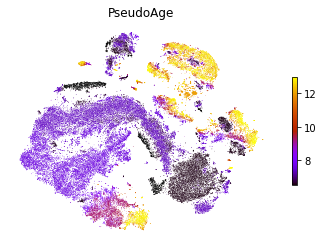

In [59]:
embedding = 'TSNE'

with loompy.connect(f, 'r') as ds:
    fig, ax = plt.subplots()
    age = ds.ca.PseudoAge
    im = ax.scatter(ds.ca[embedding][:,0],ds.ca[embedding][:,1], cmap='gnuplot', c=age, vmin = np.quantile(age, .01), vmax = np.quantile(age, .99), marker='.', lw=0, s=1)
    fig.colorbar(im, ax=ax, orientation='vertical', shrink=.5)
    ax.axis("off")
    ax.set_title(f'PseudoAge')
    plt.savefig('/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/PseudoAge.png')

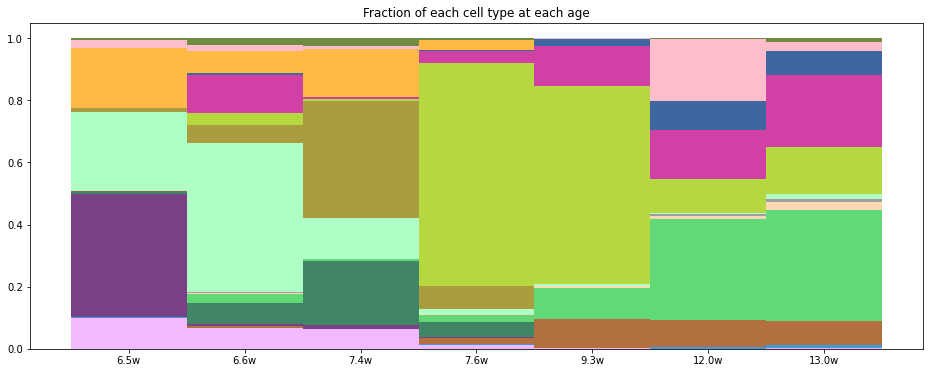

In [139]:
from matplotlib.colors import ListedColormap

with loompy.connect(f) as ds:

    Class = np.unique(ds.ca.Class_labels) 
    ages = np.unique(ds.ca.Age)
    df = pd.DataFrame([])

    for i, a in enumerate(ages): 
        cls, cells = np.unique(ds.ca.Class_labels[ds.ca.Age == a], return_counts=True)
        fraction = np.nan_to_num(cells / np.sum(cells))

        d = {c: x for c,x in zip(cls, fraction)}
        d['Age'] =  a
        data = pd.Series(d)
        df = df.append(data, ignore_index=True)
    df = df.fillna(0)
    df.sort_values(by='Age')
    
    color = colorize(Class) 
    colors = colorize(Class)
    cmp = ListedColormap(colors, name='cmp')
    
    fig, ax = plt.subplots(figsize=(16,6))

    width = 1
    bottoms = np.zeros(len(df['Age']))
    for i, cls in enumerate(Class):
        ax.bar(df['Age'].astype(str)+'w', df[cls], width, bottom=bottoms, label=cls, alpha=.75, color=colors[i]);
        bottoms = bottoms + df[cls]
    ax.set_title(f'Fraction of each cell type at each age')
    
#     df.plot(x='Age', kind='bar', stacked=True,
#             ax = ax, colormap = cmp,
#             title='Fraction of cell types at each timepoint')

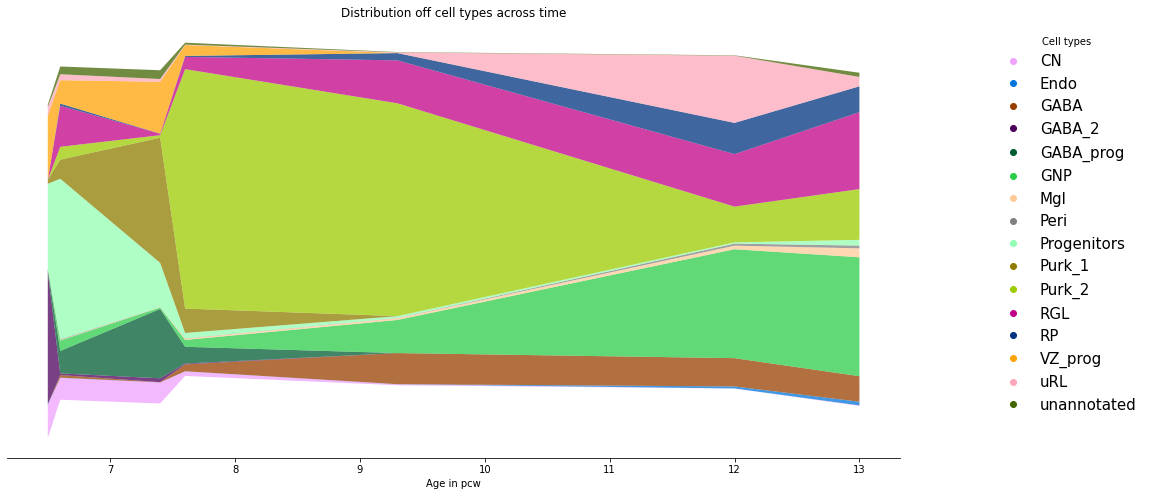

In [190]:
vals = {}

for k, v in sorted(df.items()):
    if k is not 'Age':
        vals[k] = v

color_dict = {k:v for k, v in zip(vals.keys(), colors)}
        
fig, ax = plt.subplots(figsize = (16,8))
ax.stackplot(df['Age'], vals.values(), labels=vals.keys(), colors=colors, alpha=.75);
ax.set_xlabel(f'Age in pcw')
ax.set_title(f'Distribution off cell types across time')
# Remove spines
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
ax.spines['left'].set_visible(False);
ax.set_yticks([])

h = lambda c: plt.Line2D([], [], color=c, ls="", marker="o")
legend1 = ax.legend(handles=[h(color_dict[k]) for k in vals.keys()], labels=list(vals.keys()), 
                        bbox_to_anchor=(0.73, 0., 0.55, 1.0), title='Cell types', title_fontsize=10, frameon=False, fontsize=15)
# plt.savefig('/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/Cell_type_distribution.png')

In [18]:
f_peaks = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'
f_agg = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.agg.loom'

markers = {}

with loompy.connect(f_peaks, 'r') as ds:
    with loompy.connect(f_agg, 'r') as dsagg:
        print(dsagg.layers.keys())
        print(dsagg.ca.keys())
        for i in range(dsagg.shape[1]):
            x = np.where(dsagg['residuals'][:,i] == np.max(dsagg['residuals'][:,i]))[0]
            markers[dsagg.ca.Class_labels[i]] = x

['', 'CPM', 'binary', 'log2fc', 'marker_peaks', 'residuals']
['Age', 'AutoAnnotation', 'CPM_thres', 'Chemistry_multiome_atac', 'Chemistry_v1', 'Chemistry_v1_1', 'Class', 'Class_labels', 'Clusters_0', 'Clusters_1', 'Clusters_10', 'Clusters_11', 'Clusters_12', 'Clusters_13', 'Clusters_14', 'Clusters_15', 'Clusters_16', 'Clusters_17', 'Clusters_18', 'Clusters_19', 'Clusters_2', 'Clusters_20', 'Clusters_21', 'Clusters_22', 'Clusters_23', 'Clusters_24', 'Clusters_25', 'Clusters_26', 'Clusters_27', 'Clusters_28', 'Clusters_29', 'Clusters_3', 'Clusters_30', 'Clusters_31', 'Clusters_32', 'Clusters_33', 'Clusters_34', 'Clusters_35', 'Clusters_36', 'Clusters_37', 'Clusters_38', 'Clusters_39', 'Clusters_4', 'Clusters_40', 'Clusters_41', 'Clusters_42', 'Clusters_43', 'Clusters_44', 'Clusters_45', 'Clusters_46', 'Clusters_47', 'Clusters_48', 'Clusters_49', 'Clusters_5', 'Clusters_50', 'Clusters_51', 'Clusters_52', 'Clusters_53', 'Clusters_54', 'Clusters_55', 'Clusters_56', 'Clusters_57', 'Clusters_

## Export UMAP etc

In [10]:
f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'

# out = {}

# with loompy.connect(f) as ds:
#     for k in ds.ca:
#         out[k] = ds.ca[k]
        
pkl.dump(out, open('/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/column_attr.pkl', 'wb'))

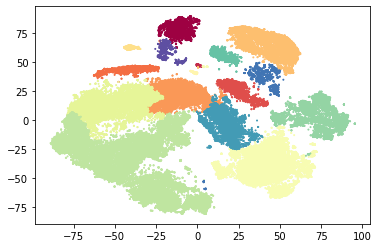

In [15]:
plt.scatter(out['TSNE'][:,0], out['TSNE'][:,1], s=1, c=out['Class'], cmap='Spectral')

In [20]:
import pickle as pkl

data = pkl.load(open(file_name, 'rb'))